In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
"""
This are constants defined in the artificial neuron model.
"""
tau = 0.020  # Membrane time constant in seconds
R = 3e7  # Membrane resistance in ohms
U_rest = -0.07  # Resting potential in volts
theta = -0.030  # Default spike threshold in volts
spike_volt = 0.1  # Voltage at spike in volts
arp = 0.006  # Absolute refractory period in seconds (6 ms)
background_I = 3e-9  # Background noise current in amperes


In [3]:
# Loading the neurons and putting them effectively
real_spike = np.loadtxt('DataSetCoursework_AMA.txt')
real_spike = real_spike[:, :-2]
first_neuron = real_spike[:, 0]
second_neuron = real_spike[:, 1]
third_neuron = real_spike[:, 2]
fourth_neuron = real_spike[:, 3]
fifth_neuron = real_spike[:, 4]
sixth_neuron = real_spike[:, 5]

# Total simulation period also the total number of rows in the real neuron
dt = 1e-2
total_simulation_time = dt * len(real_spike)
print(sixth_neuron.shape, sixth_neuron.ndim)
print(f'The total simulation time is {total_simulation_time} seconds')

(4836,) 1
The total simulation time is 48.36 seconds


In [4]:
a = np.atleast_2d(sixth_neuron)

b = np.where(sixth_neuron > 0)
a.shape, a.ndim, real_spike.shape, b, b[0]

((1, 4836),
 2,
 (4836, 6),
 (array([  67,   99,  104,  106,  112,  145,  147,  416,  635,  970, 1141,
         1152, 1153, 1190, 1302, 1312, 1326, 1359, 1371, 1408, 1520, 1539,
         1610, 1665, 1725, 1761, 1819, 1821, 1855, 1880, 1881, 1896, 1921,
         1946, 1982, 2062, 2176, 2263, 2264, 2296, 2315, 2325, 2387, 2402,
         2413, 2486, 2585, 2834, 2858, 2920, 3018, 3091, 3094, 3155, 3164,
         3195, 3199, 3265, 3394, 3398, 3422, 3462, 3480, 3490, 3628, 3659,
         3801, 3838, 3865, 3914, 4001, 4038, 4100, 4126, 4139, 4189, 4222,
         4223, 4278, 4307, 4344, 4380, 4584, 4612, 4807]),),
 array([  67,   99,  104,  106,  112,  145,  147,  416,  635,  970, 1141,
        1152, 1153, 1190, 1302, 1312, 1326, 1359, 1371, 1408, 1520, 1539,
        1610, 1665, 1725, 1761, 1819, 1821, 1855, 1880, 1881, 1896, 1921,
        1946, 1982, 2062, 2176, 2263, 2264, 2296, 2315, 2325, 2387, 2402,
        2413, 2486, 2585, 2834, 2858, 2920, 3018, 3091, 3094, 3155, 3164,
        3195, 31

In [5]:
def plot_spike(spike, duration, title="Plot of Spike Raster"):
    """
    Function to plot a spike raster.

    Parameters:
    - spike (ndarray): Input spike data, where each column represents a neuron.
                       For a single neuron, it's a 1D array (time steps).
    - duration (float): Total simulation duration in seconds.
    - title (str): Title for the plot.
    """

    # Check if the input contains a single or multiple neurons
    if spike.ndim == 1:  # Single neuron case (1D array)
        n_neurons = 1
        spike = spike[:, np.newaxis]  # Convert to 2D array for consistent handling
    else:
        n_neurons = spike.shape[1]

    print(f"Number of neurons: {n_neurons}, Spike shape: {spike.shape}")

    # Get the spike times
    spike_times, neurons = np.where(spike > 0)

    # Initialize the plot
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Neurons")

    # Scatter plot for spikes
    plt.scatter(spike_times, neurons + 1, marker="|", color="black", s=100)

    # Add y-axis ticks and labels
    if n_neurons == 1:
        plt.yticks([1], ["Neuron 1"])
    else:
        plt.yticks(
            ticks=np.arange(1, n_neurons + 1),
            labels=[f"Neuron {i + 1}" for i in range(n_neurons)]
        )

    # Set the x-axis duration
    plt.xlim([0, spike.shape[0]])  # Match time steps to spike length
    plt.grid(axis="y", alpha=0.25, linestyle="--")
    plt.tight_layout()
    plt.show()


Number of neurons: 1, Spike shape: (4836, 1)


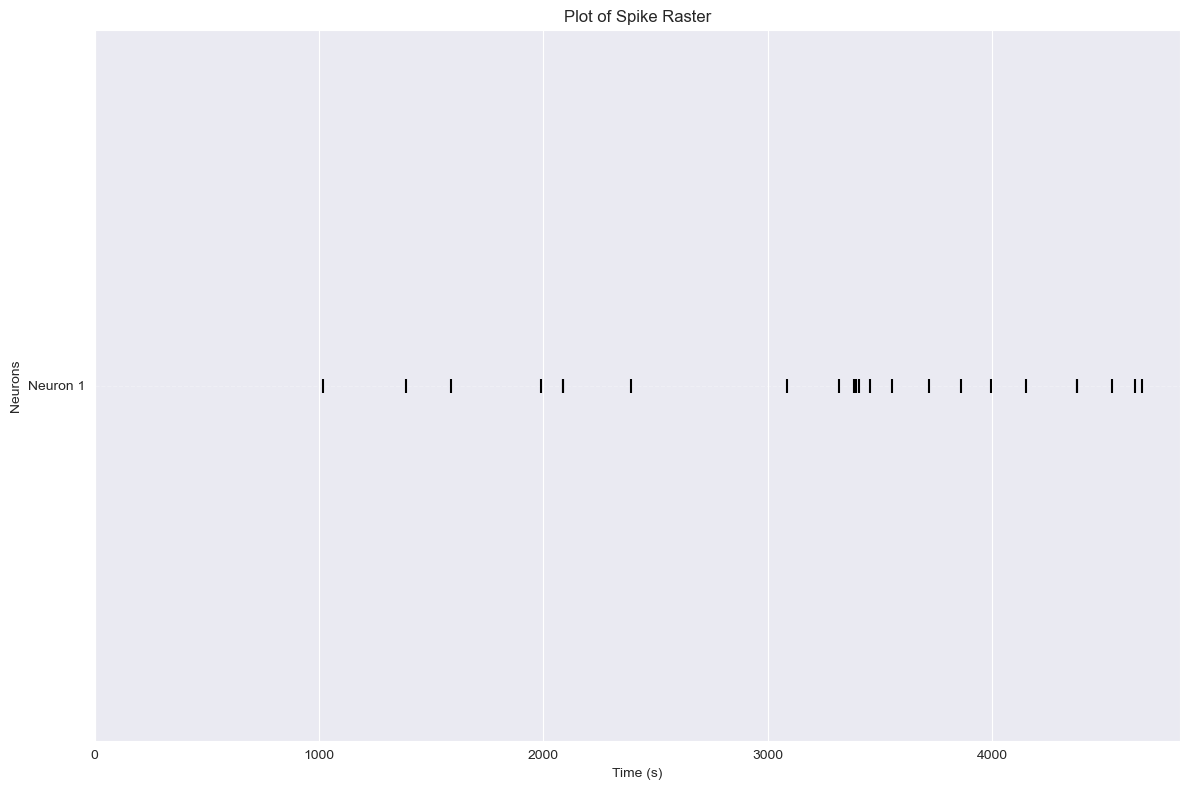

In [6]:
plot_spike(second_neuron, total_simulation_time)

In [7]:
def leaky_if_3(input_currents, duration, dt):
    """
    Leaky Integrate-and-Fire model:
    Updates to inject spikes at times provided in psc as a 1D array.

    Args:
        input_currents (dict): Dictionary with `U_0`, `psc`, and `ipsc`.
            - `psc`: 1D array specifying times of excitatory spikes.
            - `ipsc`: 1D array specifying times of inhibitory spikes (optional).
        duration (float): Total simulation time (seconds).
        dt (float): Simulation time step (seconds).

    Returns:
        time (np.ndarray): Time array.
        U_plot (np.ndarray): Membrane potential across all timesteps.
        spike_train (np.ndarray): Binary spike train (1 for spikes, 0 otherwise).
    """
    # Extract PSC and IPSC times
    psc = input_currents["psc"]  # Excitatory spike times
    ipsc = input_currents.get("ipsc", [])  # Inhibitory spike times (can be empty)

    U_0 = input_currents["U_0"]  # Baseline potential
    V_th = 1.0  # Threshold potential, example value
    R = 1.0  # Membrane resistance
    tau = 0.02  # Membrane time constant (20 ms)

    # Convert spike times to indices
    n_steps = int(duration / dt)
    time = np.arange(0, duration, dt)  # Discretized simulation time
    U = np.zeros_like(time)  # Initialize membrane potential
    U[0] = U_0  # Set initial potential
    spike_train = np.zeros_like(time)  # Binary spike train

    # Map `psc` and `ipsc` times to indices
    psc_indices = np.round(psc / dt).astype(int)  # Closest indices for psc
    ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []

    # Inject current when spikes occur
    psc_amplitude = 0.5
    ipsc_amplitude = -0.5

    for t in range(1, n_steps):
        # Decay membrane potential
        U[t] = U[t - 1] + (-U[t - 1] + R * 0) * (dt / tau)

        # Add PSC if a spike occurs at this time step
        if t in psc_indices:
            U[t] += psc_amplitude

        # Add IPSC if inhibitory spike occurs at this time step
        if t in ipsc_indices:
            U[t] += ipsc_amplitude

        # Check for spike
        if U[t] >= V_th:
            U[t] = 0  # Reset potential
            spike_train[t] = 1  # Record spike in spike train

    return time, U, spike_train


Number of spikes: 0.0
Length of spike train:  (4836,)
Number of neurons: 1, Spike shape: (4836, 1)


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


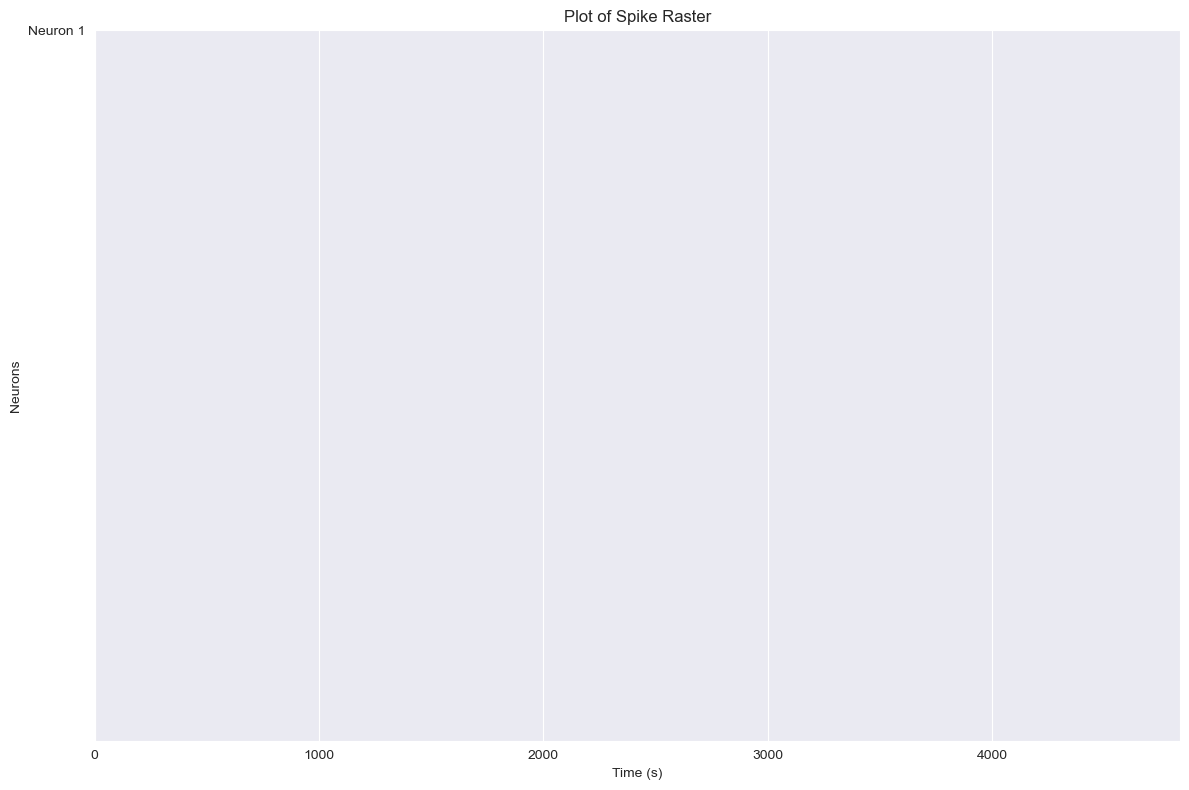

In [8]:
ipsc = np.array([])
psc = np.concatenate([np.arange(0.05, 0.055, dt), np.arange(0.1, 0.1005, dt)])

# Input currents
input_currents = {
    "U_0": 0.3,  # Initial potential
    "psc": psc,
    "ipsc": ipsc
}

# Simulation parameters
dt = 1e-4  # Time step
duration = total_simulation_time * 1e-2# Duration of simulation

# Run the simulation
time, U_plot, spike_train = leaky_if_3(input_currents, duration, dt)
print(f"Number of spikes: {spike_train.sum()}")
print('Length of spike train: ', spike_train.shape)
plot_spike(spike_train, duration)

Time where spikes happened (indices): [1019 1389 1590 1991 2088 2089 2392 3086 3320 3385 3394 3408 3458 3554
 3717 3862 3997 4152 4377 4378 4534 4636 4669]
Total simulation duration (in ms): 483.6
Number of spikes: 22.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3 1022 1392 1593 1994 2091 2395 3089 3323 3388 3397 3411 3461 3557
 3720 3865 4000 4155 4380 4537 4639 4672]
Number of neurons: 1, Spike shape: (4836, 1)


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


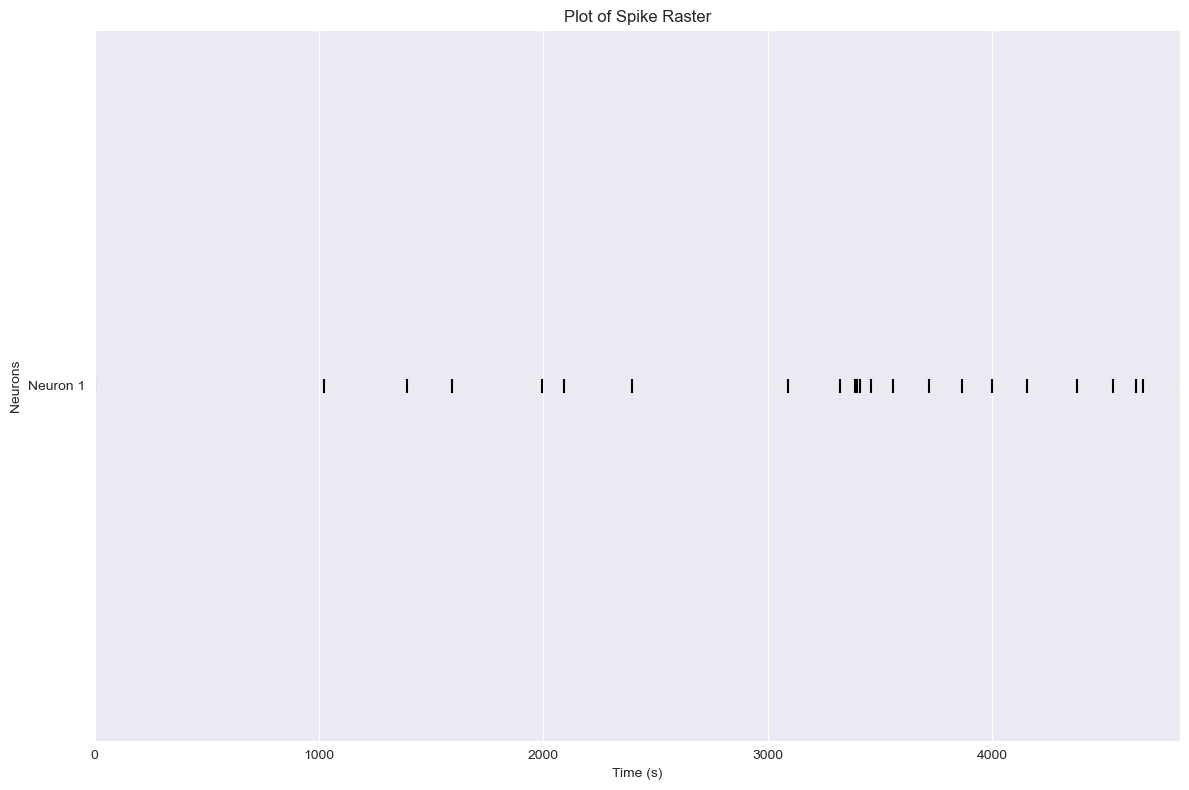

(array([0.000e+00, 1.000e-01, 2.000e-01, ..., 4.833e+02, 4.834e+02,
        4.835e+02]),
 array([ 0.3, -1.2,  0. , ...,  0. ,  0. ,  0. ]),
 array([0., 0., 1., ..., 0., 0., 0.]))

In [13]:
"""
Dealing with first neuron to simulate its spike train:
1. Obtain psc from the first neuron as the indices where spikes occur.
2. Use those indices to create a spike train, ensuring all time-related variables are consistently scaled to ms.
3. Ensure the simulation retains the expected duration and proper alignment in ms.
"""


def artificial_neuron_simulation(neuron=first_neuron, ipsc=np.array([])):
    neuron_spike_index = np.where(neuron > 0)[0] + 1
    print(f'Time where spikes happened (indices): {neuron_spike_index}')
    # Simulation time step
    dt = 1e-4  # Time step (in seconds, 0.1 ms)
    # Convert spike indices to time in **ms**:
    neuron_spike_times = neuron_spike_index * dt * 1000  # Convert to milliseconds
    difference = 0.0001 * 1000  # Duration of PSC in ms
    psc = np.concatenate([
        np.arange(spike_time, spike_time + difference, dt * 1000)  # Define PSC windows in ms
        for spike_time in neuron_spike_times
    ])
    # No inhibitory spikes
    ipsc = np.array([])
    # Input currents
    input_currents = {
        "U_0": 0.3,  # Initial potential
        "psc": psc,  # Excitatory spike times in ms
        "ipsc": ipsc  # No inhibitory spike currents
    }
    # Total simulation duration in ms (make sure it accounts for all spikes)
    total_simulation_time = int(neuron.shape[0])  # Retain the shape of the neuron.
    duration = total_simulation_time * dt * 1000  # Convert total simulation duration to ms
    print(f'Total simulation duration (in ms): {duration}')
    # Run the simulation (ensure durations match)
    time, U_plot, spike_train = leaky_if_3(input_currents, duration, dt * 1000)
    # Print results
    print(f"Number of spikes: {spike_train.sum()}")
    print('Length of spike train: ', spike_train.shape)
    print(f'Time where spikes happened (indices): {np.where(spike_train > 0)[0] + 1}')
    # Plot spike train
    plot_spike(spike_train, duration)

    return time, U_plot, spike_train


# Spike indices from the first neuron
artificial_neuron_simulation(neuron=second_neuron)

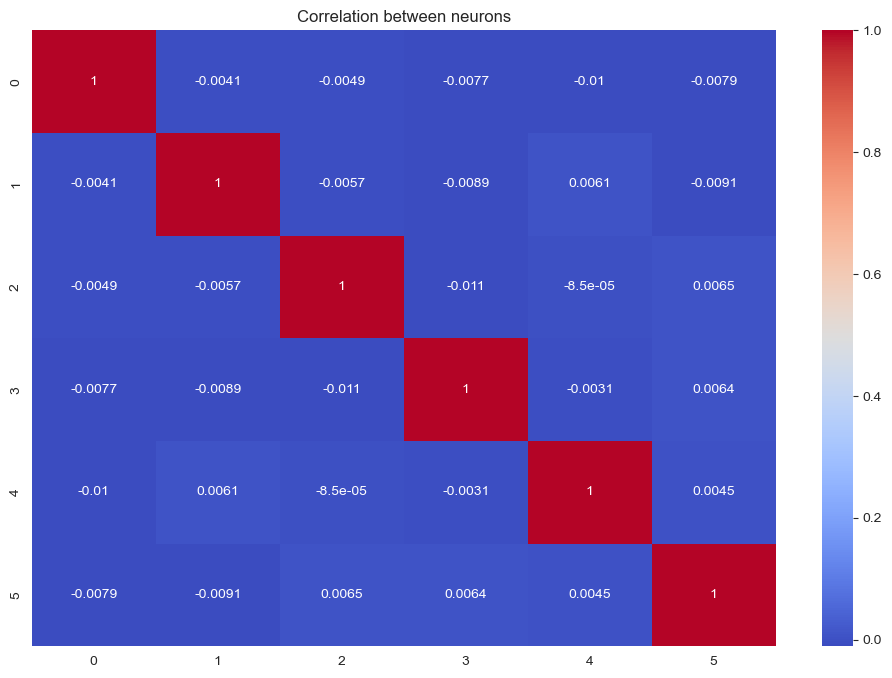

In [14]:
import seaborn as sns
Weights = np.corrcoef(real_spike.T)

plt.figure(figsize=(12, 8))
sns.heatmap(Weights, annot=True, cmap='coolwarm')
plt.title('Correlation between neurons')
plt.show()

In [15]:
Weights

array([[ 1.00000000e+00, -4.10583965e-03, -4.93130398e-03,
        -7.65645253e-03, -1.02174640e-02, -7.85721577e-03],
       [-4.10583965e-03,  1.00000000e+00, -5.73946965e-03,
        -8.91122859e-03,  6.09662418e-03, -9.14489386e-03],
       [-4.93130398e-03, -5.73946965e-03,  1.00000000e+00,
        -1.07027991e-02, -8.51389030e-05,  6.46021167e-03],
       [-7.65645253e-03, -8.91122859e-03, -1.07027991e-02,
         1.00000000e+00, -3.12576141e-03,  6.35227535e-03],
       [-1.02174640e-02,  6.09662418e-03, -8.51389030e-05,
        -3.12576141e-03,  1.00000000e+00,  4.54467556e-03],
       [-7.85721577e-03, -9.14489386e-03,  6.46021167e-03,
         6.35227535e-03,  4.54467556e-03,  1.00000000e+00]])

Time where spikes happened (indices): [ 156  233  520 1322 1420 1427 1723 1839 2166 3332 3538 3715 3744 4170
 4246 4255 4314]
Total simulation duration (in ms): 483.6
Number of spikes: 18.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3  159  236  523 1325 1423 1430 1726 1842 2169 3335 3541 3718 3747
 4173 4249 4258 4317]
Number of neurons: 1, Spike shape: (4836, 1)


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


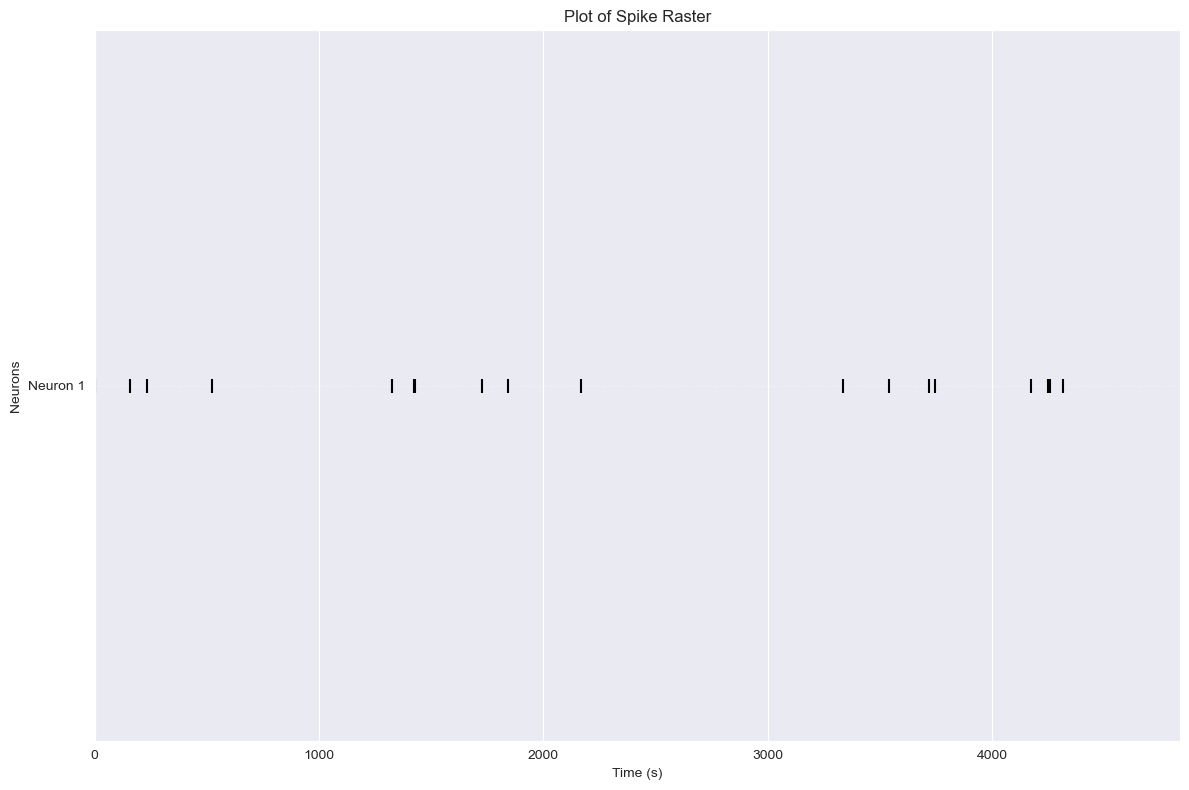

Time where spikes happened (indices): [1019 1389 1590 1991 2088 2089 2392 3086 3320 3385 3394 3408 3458 3554
 3717 3862 3997 4152 4377 4378 4534 4636 4669]
Total simulation duration (in ms): 483.6
Number of spikes: 22.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3 1022 1392 1593 1994 2091 2395 3089 3323 3388 3397 3411 3461 3557
 3720 3865 4000 4155 4380 4537 4639 4672]
Number of neurons: 1, Spike shape: (4836, 1)


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


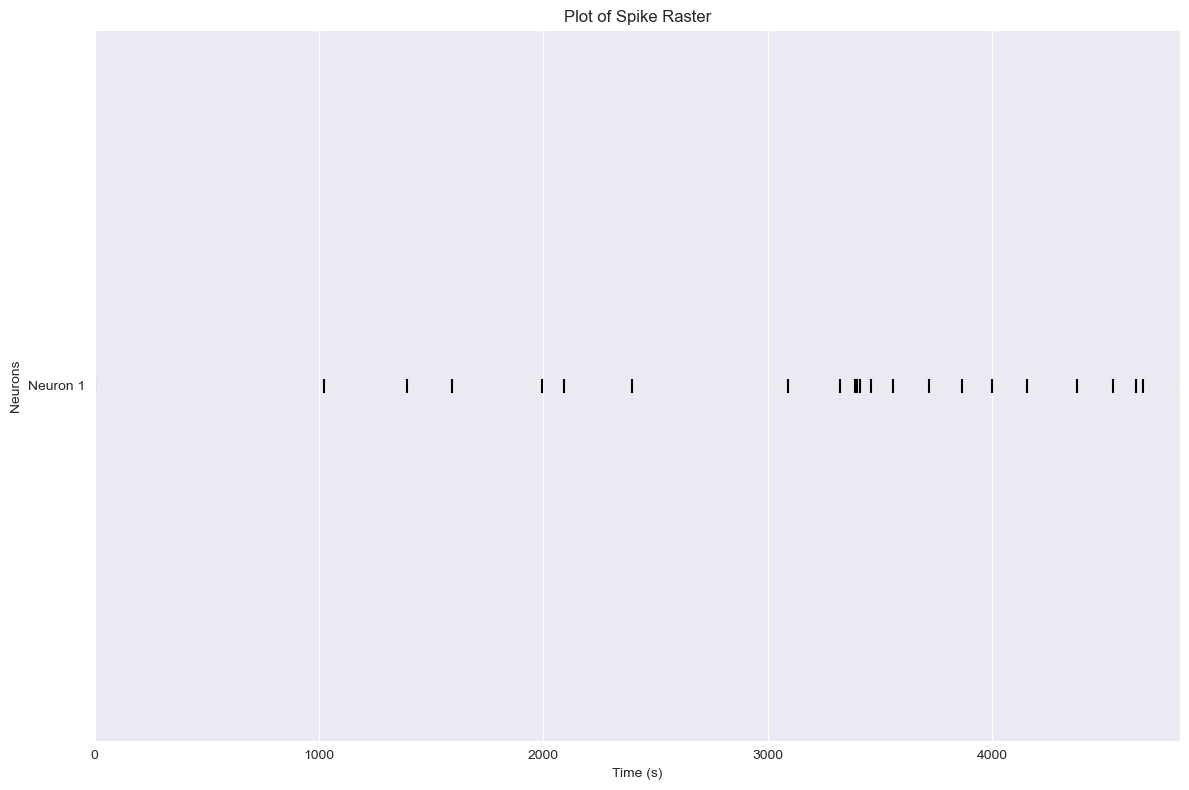

Time where spikes happened (indices): [  58  178  179  182  252  295  611  667  950 1315 1316 1317 1720 1726
 1831 1924 2148 2206 3202 3213 3222 3550 4122 4213 4251 4259 4268 4274
 4281 4354 4387 4423 4445 4828]
Total simulation duration (in ms): 483.6
Number of spikes: 32.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3   61  181  185  255  298  614  670  953 1318 1723 1729 1834 1927
 2151 2209 3205 3216 3225 3553 4125 4216 4254 4262 4271 4277 4284 4357
 4390 4426 4448 4831]
Number of neurons: 1, Spike shape: (4836, 1)


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


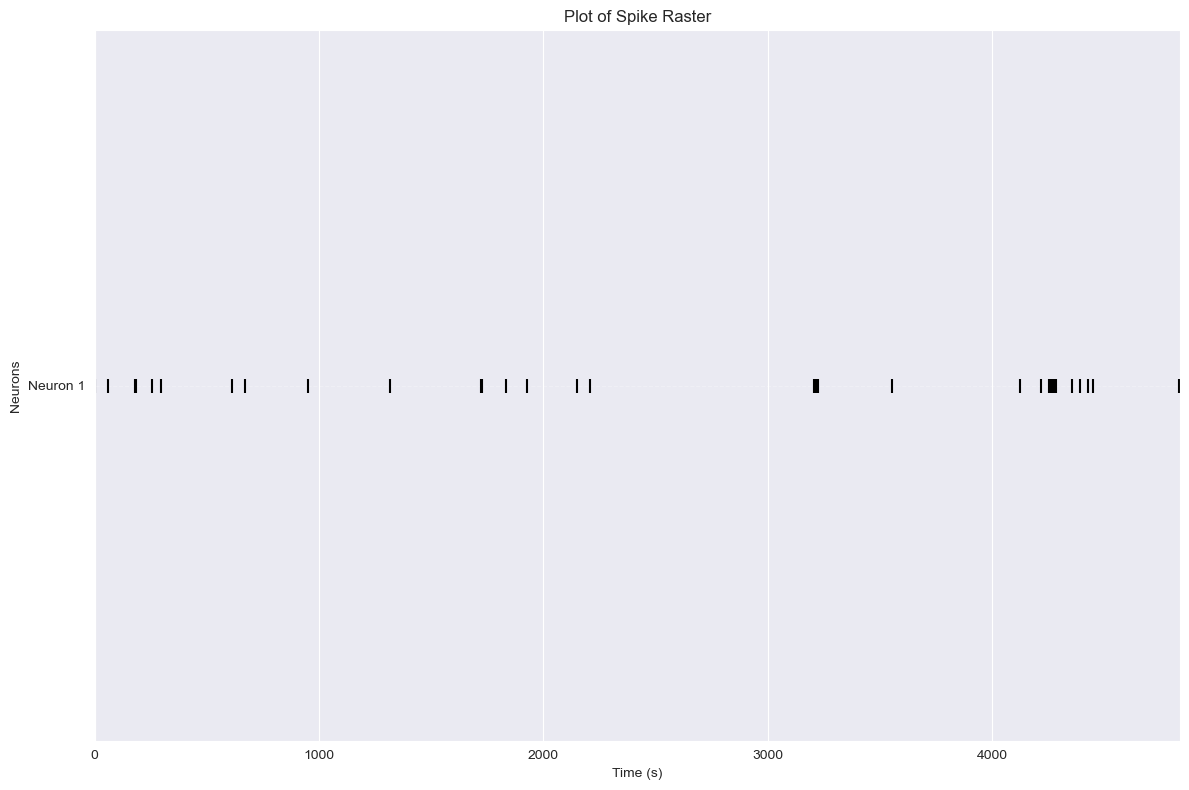

Time where spikes happened (indices): [  90 1170 1421 1423 1426 1436 1461 1530 1638 1675 1677 1694 1696 1704
 1741 1751 1886 1933 1936 1955 1972 2034 2175 2190 2194 2200 3173 3192
 3197 3235 3334 3404 3427 3494 3534 3573 3660 3667 3807 3873 3921 3932
 3936 3938 3941 3946 4074 4126 4156 4161 4172 4174 4180 4187 4191 4218
 4223 4227 4240 4252 4257 4258 4263 4265 4275 4278 4286 4295 4297 4299
 4485 4491 4558 4566 4578 4584 4589 4611 4614 4619]
Total simulation duration (in ms): 483.6
Number of spikes: 76.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3   93 1173 1424 1429 1439 1464 1533 1641 1678 1697 1707 1744 1754
 1889 1936 1939 1958 1975 2037 2178 2193 2197 2203 3176 3195 3200 3238
 3337 3407 3430 3497 3537 3576 3663 3670 3810 3876 3924 3935 3939 3942
 3945 3949 4077 4129 4159 4164 4175 4178 4183 4190 4194 4221 4226 4230
 4243 4255 4260 4266 4269 4278 4281 4289 4298 4301 4488 4494 4561 4569
 4581 4587 4592 4614 4617 4622]
Number of neurons: 1, Spike shape:

/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


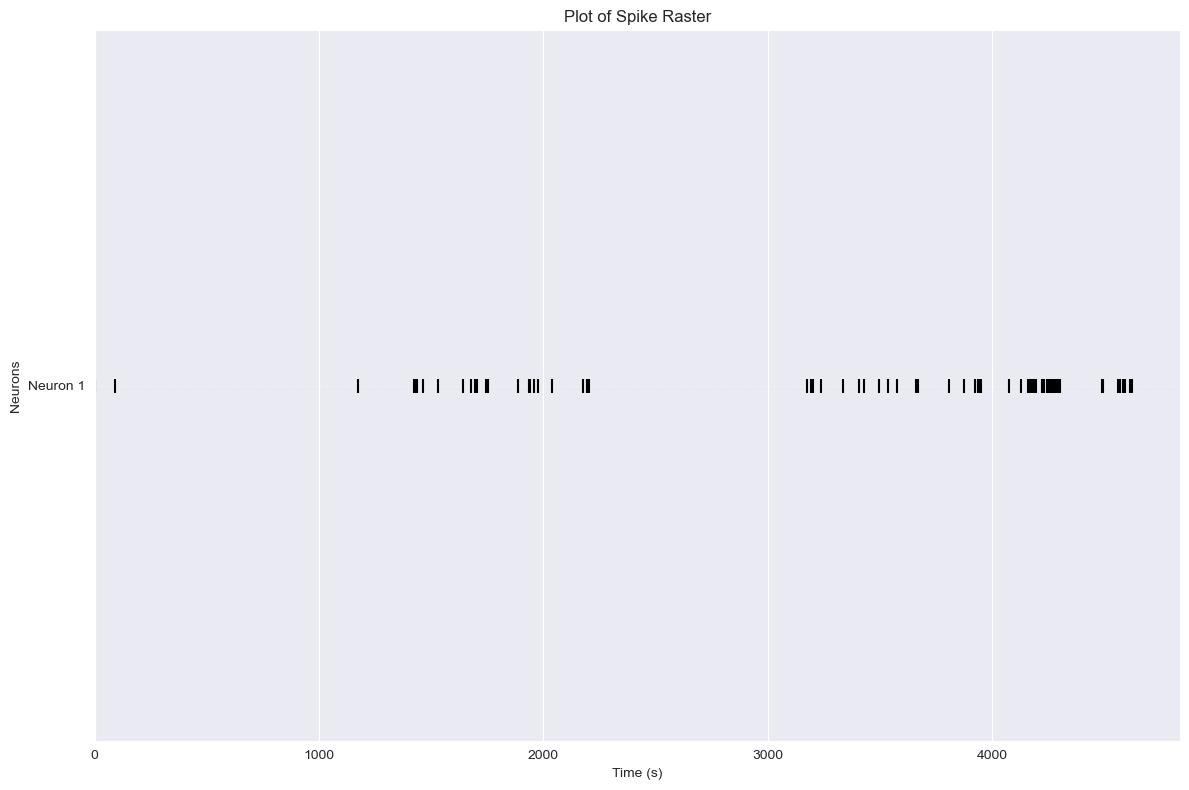

Time where spikes happened (indices): [  35   66  116  122  139  153  241  243  347  364  367  371  373  475
  539  558  599  671  717  808  923  968  975 1163 1350 1353 1360 1414
 1451 1487 1489 1534 1549 1564 1604 1632 1661 1668 1673 1680 1683 1747
 1772 1811 1815 1825 1841 1860 1893 1930 1935 1945 1948 1959 1970 1976
 1982 1991 2008 2012 2052 2104 2115 2151 2163 2186 2268 2276 2278 2296
 2362 2394 2446 2476 2547 2565 2609 2619 2698 2724 2797 2943 3006 3033
 3067 3083 3160 3163 3181 3229 3261 3284 3427 3455 3469 3470 3552 3642
 3644 3663 3695 3698 3700 3708 3723 3799 3825 3856 3867 3886 3897 3939
 3943 4023 4046 4055 4111 4119 4123 4131 4140 4178 4188 4233 4240 4247
 4271 4274 4294 4308 4315 4327 4344 4410 4440 4541 4562 4594 4651]
Total simulation duration (in ms): 483.6
Number of spikes: 137.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3   38   69  119  125  142  156  244  247  350  367  370  374  377
  478  542  561  602  674  720  811  926  971  978

/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


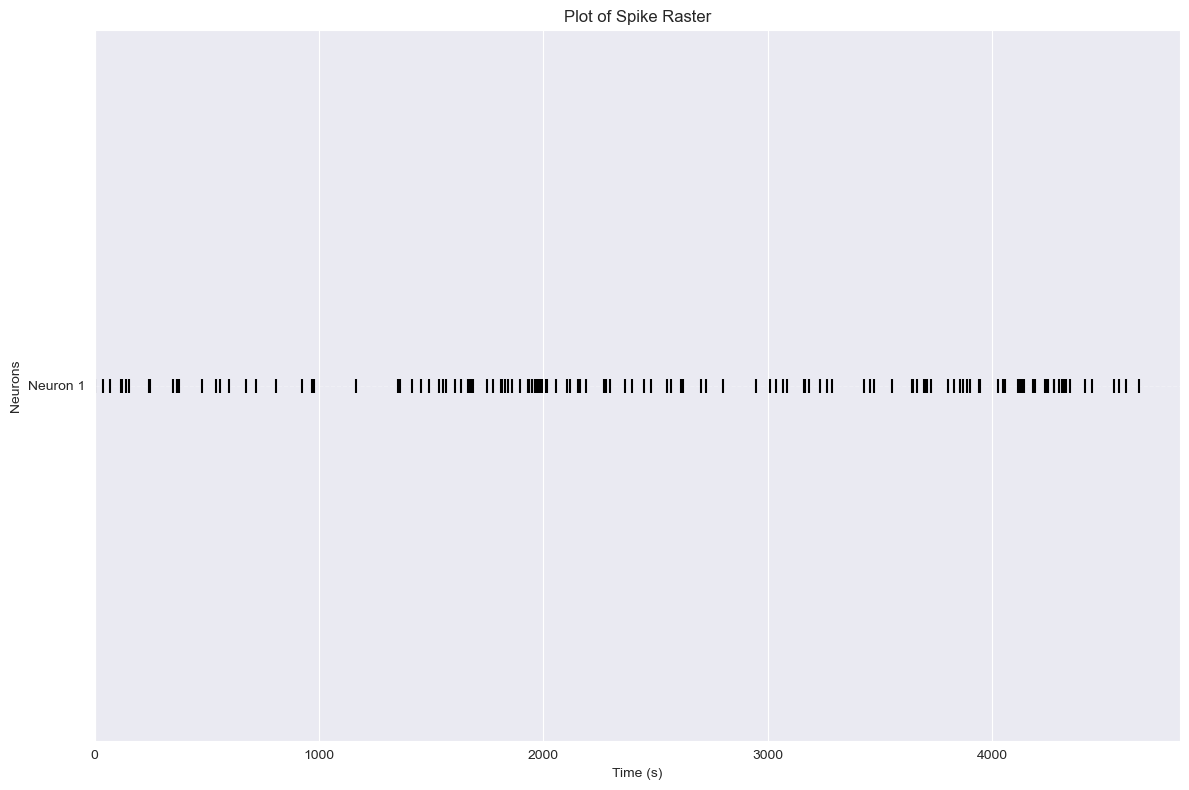

Time where spikes happened (indices): [  68  100  105  107  113  146  148  417  636  971 1142 1153 1154 1191
 1303 1313 1327 1360 1372 1409 1521 1540 1611 1666 1726 1762 1820 1822
 1856 1881 1882 1897 1922 1947 1983 2063 2177 2264 2265 2297 2316 2326
 2388 2403 2414 2487 2586 2835 2859 2921 3019 3092 3095 3156 3165 3196
 3200 3266 3395 3399 3423 3463 3481 3491 3629 3660 3802 3839 3866 3915
 4002 4039 4101 4127 4140 4190 4223 4224 4279 4308 4345 4381 4585 4613
 4808]
Total simulation duration (in ms): 483.6
Number of spikes: 79.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3   71  103  108  116  149  420  639  974 1145 1156 1194 1306 1316
 1330 1363 1375 1412 1524 1543 1614 1669 1729 1765 1823 1859 1884 1900
 1925 1950 1986 2066 2180 2267 2300 2319 2329 2391 2406 2417 2490 2589
 2838 2862 2924 3022 3095 3098 3159 3168 3199 3203 3269 3398 3402 3426
 3466 3484 3494 3632 3663 3805 3842 3869 3918 4005 4042 4104 4130 4143
 4193 4226 4282 4311 4348 4384 4588 4616

/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_3411/2828728459.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


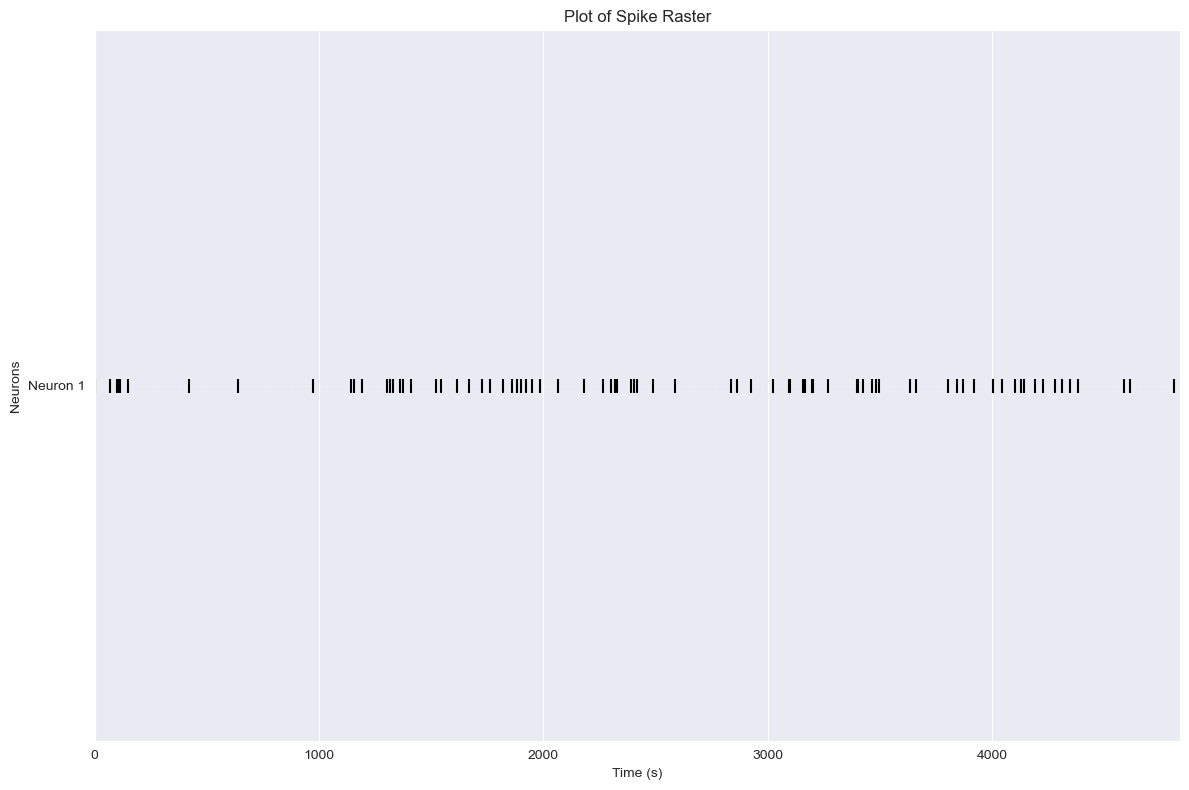

In [16]:
"""
Now for all six neurons we are going to simulate the network.
1. We have already demo using one spike. which is good.
2. We use psc from both neurons and ipsc to demo all neurons.
"""
time, U_plot, neuron_1 = artificial_neuron_simulation(first_neuron)
time, U_plot, neuron_2 = artificial_neuron_simulation(second_neuron, ipsc=np.array([]))
time, U_plot, neuron_3 = artificial_neuron_simulation(third_neuron, ipsc=np.array([]))
time, U_plot, neuron_4 = artificial_neuron_simulation(fourth_neuron, ipsc=np.array([]))
time, U_plot, neuron_5 = artificial_neuron_simulation(fifth_neuron, ipsc=np.array([]))
time, U_plot, neuron_6 = artificial_neuron_simulation(sixth_neuron, ipsc=np.array([]))



Weight between neuron 2 and 0: -0.004931303976608717
Weight between neuron 2 and 1: -0.005739469652248193
Weight between neuron 2 and 2: 1.0
Weight between neuron 2 and 3: -0.010702799103480909
Weight between neuron 2 and 4: -8.513890299282167e-05
Weight between neuron 2 and 5: 0.0064602116676337655
Time where spikes happened (indices): [  58  178  179  182  252  295  611  667  950 1315 1316 1317 1720 1726
 1831 1924 2148 2206 3202 3213 3222 3550 4122 4213 4251 4259 4268 4274
 4281 4354 4387 4423 4445 4828]
Total simulation duration (in ms): 483.6
Number of spikes: 32.0
Length of spike train:  (4836,)
Time where spikes happened (indices): [   3   61  181  185  255  298  614  670  953 1318 1723 1729 1834 1927
 2151 2209 3205 3216 3225 3553 4125 4216 4254 4262 4271 4277 4284 4357
 4390 4426 4448 4831]
Number of neurons: 1, Spike shape: (4836, 1)


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_1245/1136779825.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


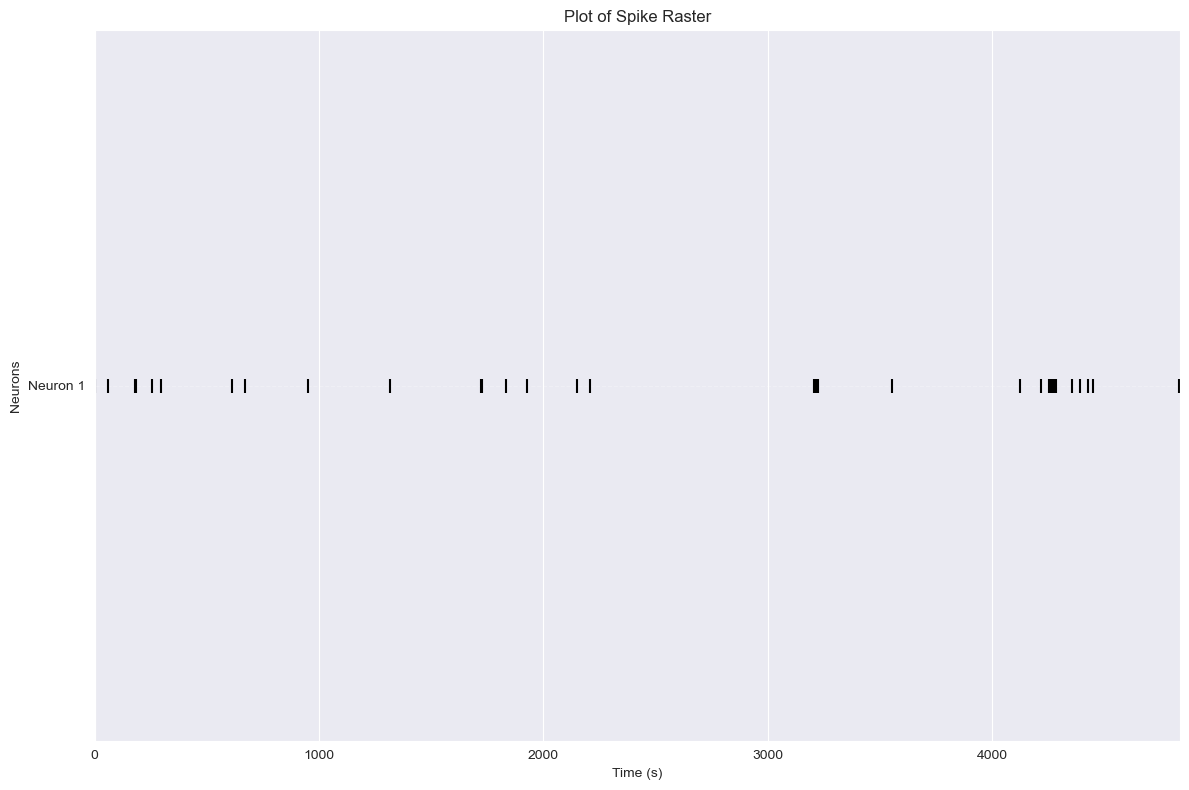

In [15]:
neuron_idx = 2
Weights = np.corrcoef(real_spike.T)
all_spike_train = np.zeros((real_spike.shape[0], 6))
ipsc = []
for other_neuron, weight in enumerate(Weights[:, neuron_idx]):
    print(f'Weight between neuron {neuron_idx} and {other_neuron}: {weight}')
    if other_neuron != neuron_idx:
        spike_times = np.where(all_spike_train[:, other_neuron] > 0)[0]
        ipsc_times = spike_times * dt * 1000 * weight
        ipsc.extend(ipsc_times)
ipsc = np.array(ipsc)
ipsc.sort()
time, U_plot, spike_train = artificial_neuron_simulation(third_neuron, ipsc=ipsc)

In [16]:
def simulate_network(neurons, duration):
    pass

In [17]:
def plot_network(neurons, duration):
    pass